# STM Transit Delay Data Preparation

## Overview

This notebook cleans and merges data collected from [STM](https://www.stm.info/en/about/developers), [Open-Meteo](https://open-meteo.com/en/docs) and [Tomtom](https://developer.tomtom.com/) and prepares it for data analysis and/or preprocessing.

## Data Description

### STM Schedule

`trip_id`: Unique identifier for the transit trip.<br>
`arrival_time`, `departure_time`: Scheduled arrival and departure time.<br>
`stop_id`: Unique identifier of a stop.<br>
`stop_sequence`: Sequence of a stop, for ordering.

### STM Stops

`stop_id`: Unique identifier of a stop.<br>
`stop_code`: Bus stop or metro station number.<br>
`stop_name`: Bus stop or metro station name<br>
`stop_lat`, `stop_lon`: Stop coordinates.<br>
`stop_url`: Stop web page.<br>
`location_type`: Stop type.<br>
`parent_station`: Parent station (metro station with multiple exits).<br>
`wheelchair_boarding`: Indicates if the stop is accessible for people in wheelchair, 0 meaning "no information", 1 being "accessible" and 2 being "not accessible".

### STM Trips

`route_id`:  Unique identifier for the bus or metro line.<br>
`service_id`: Identifies a set of dates when service is available for one or more routes.<br>
`trip_id`: Unique identifier for the transit trip.<br>
`trip_headsign`: Direction of the trip (Nord, South, West, East).<br>
`direction_id`: Boolean value for the direction.<br>
`shape_id`: Identifies a geospatial shape describing the vehicle travel path for a trip.
`wheelchair_accessible`: Indicates wheelchair accessibility, 0 meaning "no information", 1 being "accessible" and 2 being "not accessible".<br>
`note_fr`, `note_en`: Additionnal comment in French and English.

### STM Real-time Trip Updates

`current_time`: Timestamp when the data was fetched from the GTFS, in milliseconds.<br>
`trip_id`: Unique identifier for the transit trip.<br>
`route_id`: Unique identifier for a bus or metro line.<br>
`start_date`: Start date of the transit trip.<br>
`stop_id`: Unique identifier of a stop.<br>
`arrival_time`, `departure_time`: Realtime arrival and departure time, in seconds<br>
`schedule_relationship`: State of the trip, 0 meaning "scheduled", 1 meaning "skipped" and 2 meaning "no data".

### STM Real-time Vehicle Positions

`current_time`: Timestamp when the data was fetched from the GTFS, in milliseconds.<br>
`vehicle_id`: Unique identifier for a vehicle.<br>
`trip_id`: Unique identifier for the transit trip.<br>
`route_id`: Unique identifier for a bus or metro line.<br>
`start_date`: Start date of a transit trip.<br>
`start_time`: Start time of a transit trip.<br>
`latitude`, `longitude`: Vehicle current position.<br>
`bearing`: Direction that the vehicle is facing, from 0 to 360 degrees.<br>
`speed`: Momentary speed measured by the vehicle, in meters per second.<br>
`stop_sequence`: Refers to the stop that the vehicle is either on its way to, or already stopped at.<br>
`status`: Vehicle stop status in relation with a stop that it's currently approaching or is at, 1 being "stopped at" and 2 being "in transit to".<br>
`timestamp`: Timestamp when STM updated the data, in seconds.<br>
`occupancy_status`: Degree of passenger occupancy, ranging from 1 (empty) to 7 (not accepting passengers).

### STM Service Alerts

`start_time`: Start time of the alert, in seconds.<br>
`end_time`: End time of the alert, in seconds.<br>
`route_id`: Unique identifier for a bus or metro line.<br>
`stop_id`: Unique identifier of a stop.

### STM Route Types

`route_id`: Unique identifier for a bus or metro line.<br>
`route_type`: Type of bus line (e.g. Night)<br>

### Open-Meteo Weather Archive

`time`: Date and hour or the weather.<br>
`temperature`: Air temperature at 2 meters above ground, in Celsius.<br>
`relative_humidity`: Relative humidity at 2 meters above ground, in percentage.<br>
`dew_point`: Dew point temperature at 2 meters above ground, in Celsius.<br>
`precipitation`: Total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters.<br>
`pressure`: Atmospheric air pressure reduced to mean sea level (msl), in hPa.<br>
`visibility`: Viewing distance in meters.<br>
`cloud_cover`: Total cloud cover as an area fraction.<br>
`windspeed`: Wind speed at 10 meters above ground, in kilometers per hour.<br>
`wind_direction`: Wind direction at 10 meters above ground.<br>
`wind_gusts`: Gusts at 10 meters above ground as a maximum of the preceding hour.<br>

### Tomtom Traffic Incidents

`category`: Category of the incident.<br>
`start_time`: Start time of the incident, in ISO8601 format.<br>
`end_time`: End time of the incident, in ISO8601 format.<br>
`length`: Length of the incident in meters.<br>
`delay`: Delay in seconds caused by the incident (except road closures).<br>
`magnitude_of_delay`: Severity of the delay, ranging from 0 to 4 (minor to major).<br>
`last_report_time`: Date when the last time the incident was reported,in ISO8601 format.<br>
`latitude`, `longitude`: Coordinates of the incident.

## Imports

In [1]:
from datetime import datetime, timedelta, timezone
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

In [2]:
# Import custom code
sys.path.insert(0, '..')
from scripts.custom_functions import fetch_weather, LOCAL_TIMEZONE, SCHEDULE_RELATIONSHIP

In [3]:
# Import data
schedules_df = pd.read_csv('../data/download/stop_times_2025-04-30.txt')
stops_df = pd.read_csv('../data/download/stops_2025-04-30.txt')
trips_df = pd.read_csv('../data/download/trips_2025-04-30.txt')
trip_updates_df = pd.read_csv('../data/api/fetched_stm_trip_updates.csv', low_memory=False)
#positions_df =  pd.read_csv('../data/api/fetched_stm_vehicle_positions.csv', low_memory=False)
#alerts_df = pd.read_csv('../data/api/fetched_stm_service_alerts.csv')
routes_df = pd.read_csv('../data/route_types.csv')
#traffic_df = pd.read_csv('../data/api/fetched_traffic.csv')
weather_df = pd.read_csv('../data/api/fetched_historical_weather.csv')

## Merge Data

### Schedules and stops

In [4]:
# Sort values by stop sequence
schedules_df = schedules_df.sort_values(by=['trip_id', 'stop_sequence'])

In [5]:
# Add trip progress (vehicles further along the trip are more likely to be delayed)
total_stops = schedules_df.groupby('trip_id')['stop_id'].transform('count')
schedules_df['trip_progress'] = schedules_df['stop_sequence'] / total_stops

In [6]:
# Get distribution of trip progress
schedules_df['trip_progress'].describe()

count    6.629625e+06
mean     5.139220e-01
std      2.887289e-01
min      8.547009e-03
25%      2.631579e-01
50%      5.142857e-01
75%      7.647059e-01
max      1.000000e+00
Name: trip_progress, dtype: float64

In [7]:
# Merge schedules and stops
schedules_stops_df = pd.merge(left=schedules_df, right=stops_df, how='inner', left_on='stop_id', right_on='stop_code') \
	.rename(columns={'stop_id_x': 'stop_id'}) \
	.drop(['stop_id_y', 'stop_code', 'stop_url'], axis=1)

In [8]:
schedules_stops_df.columns

Index(['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence',
       'trip_progress', 'stop_name', 'stop_lat', 'stop_lon', 'location_type',
       'parent_station', 'wheelchair_boarding'],
      dtype='object')

In [9]:
# Get coordinates of previous stop
schedules_stops_df = schedules_stops_df.sort_values(by=['trip_id', 'stop_sequence'])
schedules_stops_df['prev_lat'] = schedules_stops_df.groupby('trip_id')['stop_lat'].shift(1)
schedules_stops_df['prev_lon'] = schedules_stops_df.groupby('trip_id')['stop_lon'].shift(1)

In [11]:
# Make sure scheduled arrival time has no null values
assert schedules_stops_df['arrival_time'].isna().sum() == 0

In [12]:
# Get arrival and departure time of previous stop
schedules_stops_df['prev_time'] = schedules_stops_df.groupby('trip_id')['arrival_time'].shift(1)

In [13]:
# Make sure the null coordinates are from first stops
prev_null_mask = (schedules_stops_df['prev_lat'].isna()) | (schedules_stops_df['prev_lon'].isna())
first_stop_mask = schedules_stops_df['stop_sequence'] == 1
assert prev_null_mask.sum() == first_stop_mask.sum()

In [14]:
def parse_gtfs_time(df:pd.DataFrame, date_column:str, time_column:str, milliseconds:bool=True) -> pd.Series:
	'''
	Converts GTFS time string (e.g., '25:30:00') to localized datetime
	based on the arrival or departure time.
	'''
	time_columns = ['hours', 'minutes', 'seconds']
	split_cols = df[time_column].str.split(':', expand=True).apply(pd.to_numeric)
	split_cols.columns = time_columns
	seconds_delta = (split_cols['hours'] * 3600) + (split_cols['minutes'] * 60) + split_cols['seconds']
	
	# Convert datetime to seconds
	if milliseconds:
		start_seconds = df[date_column].astype('int') / 10**9
	else:# microseconds
		start_seconds = df[date_column].astype('int') / 10**6

	# Add seconds 
	total_seconds = start_seconds + seconds_delta

	# Convert to datetime
	parsed_time = pd.to_datetime(total_seconds, origin='unix', unit='s').dt.tz_localize(LOCAL_TIMEZONE)

	return parsed_time

In [15]:
# Add column with current date
schedules_stops_df['today'] = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
schedules_stops_df['today'].head()

0   2025-05-08
1   2025-05-08
2   2025-05-08
3   2025-05-08
4   2025-05-08
Name: today, dtype: datetime64[us]

In [16]:
schedules_stops_df['parsed_time'] = parse_gtfs_time(schedules_stops_df, 'today', 'arrival_time', False)
schedules_stops_df['parsed_time'].head()

0   2025-05-08 04:55:00-04:00
1   2025-05-08 04:55:31-04:00
2   2025-05-08 04:56:04-04:00
3   2025-05-08 04:56:31-04:00
4   2025-05-08 04:56:51-04:00
Name: parsed_time, dtype: datetime64[ns, Canada/Eastern]

In [19]:
schedules_stops_df['parsed_prev_time'] = parse_gtfs_time(schedules_stops_df, 'today', 'prev_time', False)
schedules_stops_df['parsed_prev_time'].head()

0                         NaT
1   2025-05-08 04:55:00-04:00
2   2025-05-08 04:55:31-04:00
3   2025-05-08 04:56:04-04:00
4   2025-05-08 04:56:31-04:00
Name: parsed_prev_time, dtype: datetime64[ns, Canada/Eastern]

In [20]:
# Calculate expected trip duration
schedules_stops_df['trip_start'] = schedules_stops_df.groupby('trip_id')['parsed_time'].transform('min')
schedules_stops_df['trip_end'] = schedules_stops_df.groupby('trip_id')['parsed_time'].transform('max')
schedules_stops_df['exp_trip_duration'] = (schedules_stops_df['trip_end'] - schedules_stops_df['trip_start']) / pd.Timedelta(seconds=1)

In [21]:
# Get distribution
schedules_stops_df['exp_trip_duration'].describe()

count    6.388741e+06
mean     2.514089e+03
std      8.689949e+02
min      2.400000e+02
25%      1.860000e+03
50%      2.460000e+03
75%      3.120000e+03
max      6.840000e+03
Name: exp_trip_duration, dtype: float64

In [22]:
# Calculate expected delay between previous and current stop
schedules_stops_df['exp_delay_prev_stop'] = (schedules_stops_df['parsed_time'] - schedules_stops_df['parsed_prev_time']) / pd.Timedelta(seconds=1)

In [23]:
# Get distribution
schedules_stops_df['exp_delay_prev_stop'].describe()

count    6.216518e+06
mean     6.134963e+01
std      6.562132e+01
min      3.000000e+00
25%      3.500000e+01
50%      4.900000e+01
75%      6.800000e+01
max      2.220000e+03
Name: exp_delay_prev_stop, dtype: float64

In [24]:
# Assert that the null values are from first stops
assert (schedules_stops_df['stop_sequence'] == 1).sum() == schedules_stops_df['exp_delay_prev_stop'].isna().sum()

In [25]:
# Fill null values with 0 (first stop)
schedules_stops_df['exp_delay_prev_stop'] = schedules_stops_df['exp_delay_prev_stop'].fillna(0)

In [26]:
# Create GeoDataFrames for previous and current stop
sch_gdf1 = gpd.GeoDataFrame(
  schedules_stops_df[['prev_lon', 'prev_lat']],
  geometry=gpd.points_from_xy(schedules_stops_df['prev_lon'], schedules_stops_df['prev_lat']),
  crs='EPSG:4326' # WGS84 (sea level)
).to_crs(epsg=3857) # Convert to metric

sch_gdf2 = gpd.GeoDataFrame(
  schedules_stops_df[['stop_lon', 'stop_lat']],
  geometry=gpd.points_from_xy(schedules_stops_df['stop_lon'], schedules_stops_df['stop_lat']),
  crs='EPSG:4326'
).to_crs(epsg=3857)

In [27]:
# Calculate distance from previous stop
schedules_stops_df['stop_distance'] = sch_gdf1.distance(sch_gdf2)
schedules_stops_df['stop_distance'].describe()

count    6.216518e+06
mean     4.019345e+02
std      7.161721e+02
min      2.092191e+01
25%      2.490739e+02
50%      3.286372e+02
75%      4.299291e+02
max      1.965439e+04
Name: stop_distance, dtype: float64

In [28]:
# Replace null distances by zero (first stop of the trip)
schedules_stops_df['stop_distance'] = schedules_stops_df['stop_distance'].fillna(0)
assert schedules_stops_df['stop_distance'].isna().sum() == 0

In [29]:
# Get stop with largest distance
schedules_stops_df.iloc[schedules_stops_df['stop_distance'].idxmax()]

trip_id                                    281377832
arrival_time                                05:33:00
departure_time                              05:33:00
stop_id                                        61261
stop_sequence                                     13
trip_progress                                    1.0
stop_name              YUL Aéroport Montréal-Trudeau
stop_lat                                   45.456622
stop_lon                                  -73.751615
location_type                                      0
parent_station                                   NaN
wheelchair_boarding                                1
prev_lat                                   45.482527
prev_lon                                  -73.578964
prev_stop_id                                 61334.0
prev_time                                   05:12:00
today                            2025-05-08 00:00:00
parsed_time                2025-05-08 05:33:00-04:00
parsed_prev_time           2025-05-08 05:12:00

The large distance make sense because the expected time between the the previous stop and this one is 21 minutes.

In [30]:
schedules_stops_df.columns

Index(['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence',
       'trip_progress', 'stop_name', 'stop_lat', 'stop_lon', 'location_type',
       'parent_station', 'wheelchair_boarding', 'prev_lat', 'prev_lon',
       'prev_stop_id', 'prev_time', 'today', 'parsed_time', 'parsed_prev_time',
       'trip_start', 'trip_end', 'exp_trip_duration', 'exp_delay_prev_stop',
       'stop_distance'],
      dtype='object')

In [31]:
# Drop unneeded columns
schedules_stops_df = schedules_stops_df.drop([
  'prev_lat',
  'prev_lon',
  'prev_time',
  'today',
  'parsed_time',
  'parsed_prev_time',
  'trip_start', 
  'trip_end',
  ], axis=1)

### Trips

In [32]:
# Keep relevant columns
trips_df = trips_df[['trip_id', 'route_id', 'trip_headsign', 'wheelchair_accessible']]

In [33]:
# Rename trip_headsign
trips_df = trips_df.rename(columns={'trip_headsign': 'route_direction'})

In [34]:
# Translate directions
condition_list = [
	trips_df['route_direction'].str.contains('Nord'),
	trips_df['route_direction'].str.contains('Sud'),
  	trips_df['route_direction'].str.contains('Ouest'),
  	trips_df['route_direction'].str.contains('Est'),
]
label_list = ['North', 'South', 'West', 'East']

trips_df['route_direction'] = np.select(condition_list, label_list, default='Metro')	
trips_df['route_direction'].value_counts()

route_direction
West     58582
East     57518
North    28531
South    27592
Metro    12372
Name: count, dtype: int64

In [35]:
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184595 entries, 0 to 184594
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   trip_id                184595 non-null  int64 
 1   route_id               184595 non-null  int64 
 2   route_direction        184595 non-null  object
 3   wheelchair_accessible  184595 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 5.6+ MB


In [36]:
schedules_stops_df.columns

Index(['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence',
       'trip_progress', 'stop_name', 'stop_lat', 'stop_lon', 'location_type',
       'parent_station', 'wheelchair_boarding', 'prev_stop_id',
       'exp_trip_duration', 'exp_delay_prev_stop', 'stop_distance'],
      dtype='object')

In [37]:
# Merge with schedules and stops
scheduled_trips_df = pd.merge(left=schedules_stops_df, right=trips_df, how='inner', on='trip_id')

In [38]:
scheduled_trips_df.isna().sum()

trip_id                        0
arrival_time                   0
departure_time                 0
stop_id                        0
stop_sequence                  0
trip_progress                  0
stop_name                      0
stop_lat                       0
stop_lon                       0
location_type                  0
parent_station           6388741
wheelchair_boarding            0
prev_stop_id              172223
exp_trip_duration              0
exp_delay_prev_stop            0
stop_distance                  0
route_id                       0
route_direction                0
wheelchair_accessible          0
dtype: int64

In [39]:
# Get rows where wheelchair_boarding and wheelchair_accessible are different
scheduled_trips_df[scheduled_trips_df['wheelchair_boarding'] != scheduled_trips_df['wheelchair_accessible']]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,trip_progress,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding,prev_stop_id,exp_trip_duration,exp_delay_prev_stop,stop_distance,route_id,route_direction,wheelchair_accessible
11,280882183,05:01:32,05:01:32,56408,12,0.266667,Fleet / Pinedale,45.476701,-73.651768,0,NaN,2,56404.0,1920.0,17.0,196.708155,161,East,1
13,280882183,05:02:36,05:02:36,56312,14,0.311111,Fleet / Queen-Mary,45.480657,-73.648178,0,NaN,2,56310.0,1920.0,47.0,541.352107,161,East,1
16,280882183,05:04:00,05:04:00,50643,17,0.377778,Fleet / Macdonald,45.486138,-73.645128,0,NaN,2,56315.0,1920.0,23.0,258.106536,161,East,1
37,280882183,05:19:00,05:19:00,62052,38,0.844444,Van Horne / Dollard,45.519290,-73.615882,0,NaN,2,56173.0,1920.0,16.0,113.545144,161,East,1
38,280882183,05:19:53,05:19:53,61990,39,0.866667,Station Outremont (Van Horne / Outremont),45.521152,-73.614188,0,NaN,2,62052.0,1920.0,53.0,350.823560,161,East,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6388736,286597927,25:35:00,25:35:00,62199,2,1.000000,De La Gauchetière / Robert-Bourassa,45.499992,-73.565764,0,NaN,1,62202.0,900.0,900.0,5823.342923,568,North,2
6388737,286597928,25:40:00,25:40:00,62202,1,0.500000,Station REM Île-des-Soeurs,45.469756,-73.536156,0,NaN,1,NaN,900.0,0.0,0.000000,568,North,2
6388738,286597928,25:55:00,25:55:00,62199,2,1.000000,De La Gauchetière / Robert-Bourassa,45.499992,-73.565764,0,NaN,1,62202.0,900.0,900.0,5823.342923,568,North,2
6388739,286597929,25:40:00,25:40:00,62199,1,0.500000,De La Gauchetière / Robert-Bourassa,45.499992,-73.565764,0,NaN,1,NaN,900.0,0.0,0.000000,568,South,2


In [40]:
# Keep wheelchair_boarding as it's stop specific
scheduled_trips_df = scheduled_trips_df.drop('wheelchair_accessible', axis=1)

### Realtime and Scheduled Trips

In [41]:
# Convert route_id to integer
trip_updates_df['route_id'] = trip_updates_df['route_id'].str.extract(r'(\d+)')
trip_updates_df['route_id'] = trip_updates_df['route_id'].astype('int64')

In [42]:
# Get proportion of duplicates
subset = trip_updates_df.drop('current_time', axis=1).columns
duplicate_mask = trip_updates_df.duplicated(subset=subset)
print(f'{duplicate_mask.mean():.2%}')

10.35%


In [43]:
# Remove duplicates
trip_updates_df = trip_updates_df.drop_duplicates(subset=subset, keep='last')

In [44]:
# Rename arrival and departure time
trip_updates_df = trip_updates_df.rename(columns={'arrival_time': 'rt_arrival_time','departure_time': 'rt_departure_time'})

In [45]:
# Merge trip updates with schedule
merged_stm_df = pd.merge(left=trip_updates_df, right=scheduled_trips_df, how='inner', on=['trip_id', 'route_id', 'stop_id'])

In [46]:
merged_stm_df.columns

Index(['current_time', 'trip_id', 'route_id', 'start_date', 'stop_id',
       'rt_arrival_time', 'rt_departure_time', 'schedule_relationship',
       'arrival_time', 'departure_time', 'stop_sequence', 'trip_progress',
       'stop_name', 'stop_lat', 'stop_lon', 'location_type', 'parent_station',
       'wheelchair_boarding', 'prev_stop_id', 'exp_trip_duration',
       'exp_delay_prev_stop', 'stop_distance', 'route_direction'],
      dtype='object')

In [47]:
# Convert start_date to datetime
merged_stm_df['start_date_dt'] = pd.to_datetime(merged_stm_df['start_date'], format='%Y%m%d')

In [48]:
# Parse GTFS scheduled arrival and departure times
parsed_arrival_time = parse_gtfs_time(merged_stm_df, 'start_date_dt', 'arrival_time')
parsed_departure_time = parse_gtfs_time(merged_stm_df, 'start_date_dt', 'departure_time')

In [49]:
# Convert scheduled arrival and departure time to UTC datetime
merged_stm_df['sch_arrival_time'] = parsed_arrival_time.dt.tz_convert(timezone.utc)
merged_stm_df['sch_departure_time'] = parsed_departure_time.dt.tz_convert(timezone.utc)

In [50]:
# Get rows where scheduled arrival and departure time are different
merged_stm_df[merged_stm_df['sch_arrival_time'] != merged_stm_df['sch_departure_time']]

,current_time,trip_id,route_id,start_date,stop_id,rt_arrival_time,rt_departure_time,schedule_relationship,arrival_time,departure_time,...,parent_station,wheelchair_boarding,prev_stop_id,exp_trip_duration,exp_delay_prev_stop,stop_distance,route_direction,start_date_dt,sch_arrival_time,sch_departure_time
5232,1.745791e+09,284216122,470,20250427,57794,1745792340,1745792340,0,18:19:00,18:20:00,...,NaN,1,57620.0,2640.0,95.0,391.127323,East,2025-04-27,2025-04-27 22:19:00+00:00,2025-04-27 22:20:00+00:00
10326,1.745791e+09,284216100,470,20250427,60415,1745792054,1745792054,0,18:06:00,18:07:00,...,NaN,1,57818.0,3060.0,77.0,782.045238,West,2025-04-27,2025-04-27 22:06:00+00:00,2025-04-27 22:07:00+00:00
10754,1.745791e+09,284216575,747,20250427,60997,0,1745791860,0,18:06:00,18:11:00,...,NaN,1,NaN,2940.0,0.0,0.000000,East,2025-04-27,2025-04-27 22:06:00+00:00,2025-04-27 22:11:00+00:00
11788,1.745791e+09,284216533,747,20250427,60997,0,1745794440,0,18:49:00,18:54:00,...,NaN,1,NaN,2820.0,0.0,0.000000,East,2025-04-27,2025-04-27 22:49:00+00:00,2025-04-27 22:54:00+00:00
12297,1.745791e+09,284216124,470,20250427,60415,1745795640,1745795700,0,19:14:00,19:15:00,...,NaN,1,57818.0,2940.0,74.0,782.045238,West,2025-04-27,2025-04-27 23:14:00+00:00,2025-04-27 23:15:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7504518,1.746752e+09,284780839,747,20250508,60997,0,1746754560,0,21:31:00,21:36:00,...,NaN,1,NaN,1200.0,0.0,0.000000,East,2025-05-08,2025-05-09 01:31:00+00:00,2025-05-09 01:36:00+00:00
7508236,1.746752e+09,284727754,18,20250508,53851,1746754140,1746754260,0,21:29:00,21:31:00,...,NaN,1,51511.0,3000.0,80.0,271.004292,East,2025-05-08,2025-05-09 01:29:00+00:00,2025-05-09 01:31:00+00:00
7508973,1.746752e+09,284726876,161,20250508,50820,1746754980,1746755100,0,21:43:00,21:45:00,...,NaN,1,50866.0,2760.0,64.0,449.523333,West,2025-05-08,2025-05-09 01:43:00+00:00,2025-05-09 01:45:00+00:00
7510156,1.746752e+09,284780621,747,20250508,60997,0,1746753480,0,21:13:00,21:18:00,...,NaN,1,NaN,1200.0,0.0,0.000000,East,2025-05-08,2025-05-09 01:13:00+00:00,2025-05-09 01:18:00+00:00


In [51]:
# Replace 0 timestamps with NaN
merged_stm_df['rt_arrival_time'] = merged_stm_df['rt_arrival_time'].replace({0: np.nan})
merged_stm_df['rt_departure_time'] = merged_stm_df['rt_departure_time'].replace({0: np.nan})

In [52]:
# Convert realtime arrival and departure time to UTC datetime
merged_stm_df['rt_arrival_time'] = pd.to_datetime(merged_stm_df['rt_arrival_time'], origin='unix', unit='s', utc=True)
merged_stm_df['rt_departure_time'] = pd.to_datetime(merged_stm_df['rt_departure_time'], origin='unix', unit='s', utc=True)

In [53]:
# Calculate delay (realtime - scheduled)
# Start with arrival time, if null, calculate with departure time
merged_stm_df['delay'] = (merged_stm_df['rt_arrival_time'] - merged_stm_df['sch_arrival_time']) / pd.Timedelta(seconds=1)
merged_stm_df['delay'] = merged_stm_df['delay'].fillna(((merged_stm_df['rt_departure_time'] - merged_stm_df['sch_departure_time']) / pd.Timedelta(seconds=1)))

In [54]:
# Get distribution
merged_stm_df['delay'].describe()

count    7.318197e+06
mean     6.652776e+01
std      4.671457e+02
min     -1.359200e+04
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.458500e+04
Name: delay, dtype: float64

#### Handle Outliers

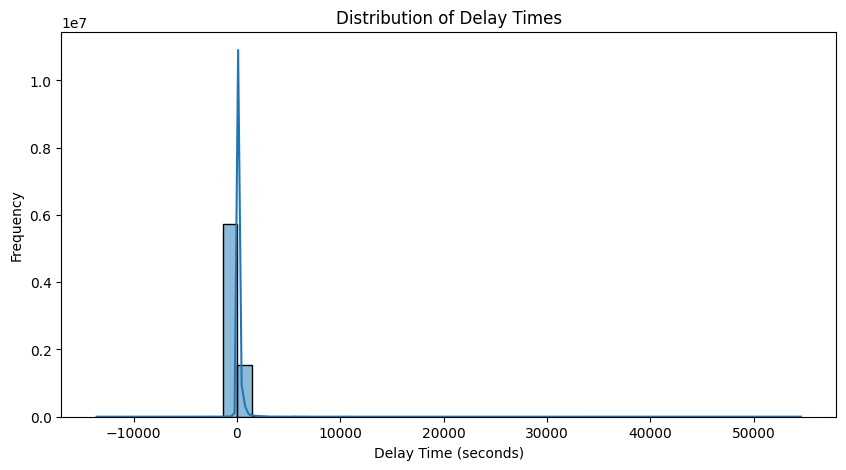

In [55]:
# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(merged_stm_df['delay'], bins=50, kde=True)
plt.title('Distribution of Delay Times')
plt.xlabel('Delay Time (seconds)')
plt.ylabel('Frequency')
plt.savefig('../images/delay_histogram.png', bbox_inches='tight')
plt.show()

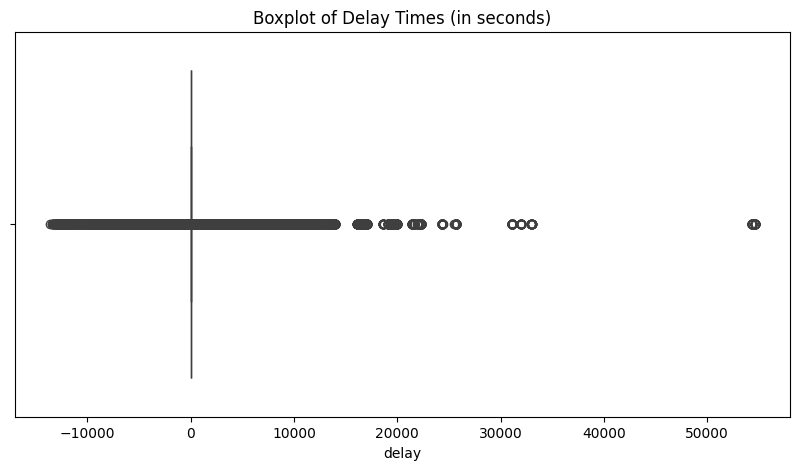

In [56]:
# Plot boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=merged_stm_df['delay'])
plt.title('Boxplot of Delay Times (in seconds)')
plt.savefig('../images/delay_boxplot.png', bbox_inches='tight')
plt.show()

The distribution of delay times is highly skewed, with most values concentrated near 0, but extending both negatively and positively in a wide range. There are extreme outliers stretching up to 55000 seconds (more than 15 hours) and also negative values going beyond -10000 seconds (almost 3 hours). Such extreme alues are unrealistic for transit delays. It's very likely they represent data entry errors, sensor glitches or edge cases (canceled trips, detours, etc.).

In [ ]:
# Filter outliers 
MIN_DELAY = -420 # 7 minutes early
MAX_DELAY = 1800 # 30 minutes late
outlier_mask = (merged_stm_df['delay'] < MIN_DELAY) | (merged_stm_df['delay'] > MAX_DELAY)

In [58]:
# Inspect outliers
outliers_df = merged_stm_df[outlier_mask]
outliers_df[['trip_id', 'route_id', 'stop_name', 'trip_progress', 'delay']].sort_values('delay', ascending=False)

,trip_id,route_id,stop_name,trip_progress,delay
161065,283553409,97,du Mont-Royal / De Lorimier,0.555556,54585.0
161068,283553409,97,du Mont-Royal / Fabre,0.638889,54585.0
161066,283553409,97,du Mont-Royal / Chabot,0.583333,54585.0
161067,283553409,97,du Mont-Royal / Papineau,0.611111,54585.0
161055,283553409,97,Rachel / Saint-Michel,0.277778,54585.0
...,...,...,...,...,...
3591404,285009528,209,Gare Roxboro-Pierrefonds,1.000000,-13318.0
2174565,285009528,209,de Pierrefonds / Gouin,0.923077,-13329.0
2174566,285009528,209,Gouin / 6e Avenue,0.948718,-13373.0
2174567,285009528,209,Gare Roxboro-Pierrefonds,0.974359,-13412.0


In [59]:
# Calculate proportion
print(f'{outlier_mask.mean():.2%}')

1.10%


In [60]:
# Remove outliers
merged_stm_df = merged_stm_df[~outlier_mask]

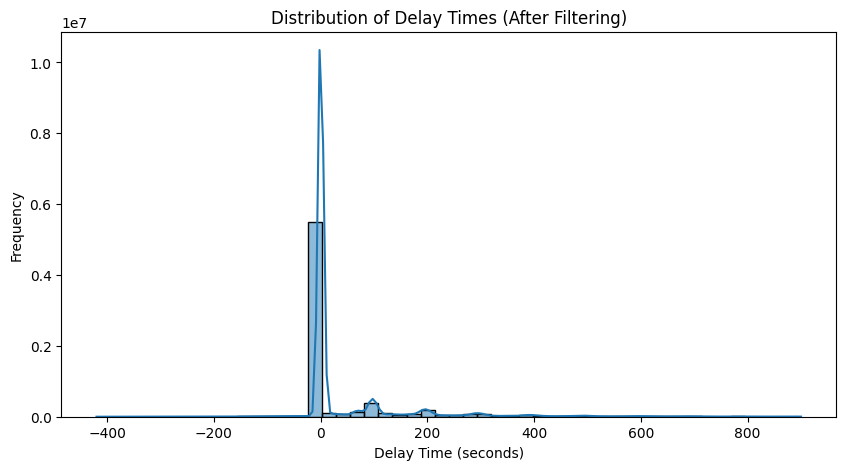

In [61]:
# Replot histogram
plt.figure(figsize=(10, 5))
sns.histplot(merged_stm_df['delay'], bins=50, kde=True)
plt.title('Distribution of Delay Times (After Filtering)')
plt.xlabel('Delay Time (seconds)')
plt.ylabel('Frequency')
plt.savefig('../images/delay_histogram_filtered.png', bbox_inches='tight')
plt.show()

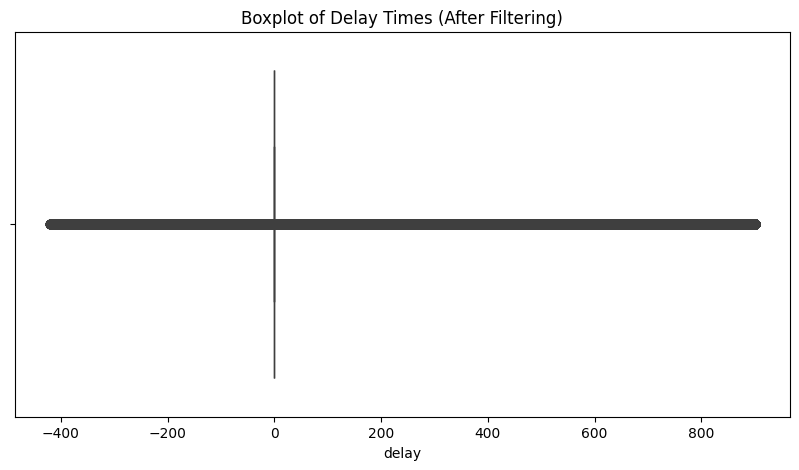

In [62]:
# Replot boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=merged_stm_df['delay'])
plt.title('Boxplot of Delay Times (After Filtering)')
plt.savefig('../images/delay_boxplot_filtered.png', bbox_inches='tight')
plt.show()

In [63]:
# Get null delays count
print(merged_stm_df['delay'].isna().sum())

194730


In [64]:
# Replace the null delays with the average delay by route, stop, day of week and hour
merged_stm_df['day_of_week'] = merged_stm_df['sch_arrival_time'].dt.day_of_week
merged_stm_df['hour'] = merged_stm_df['sch_arrival_time'].dt.hour
merged_stm_df['delay'] = merged_stm_df['delay'] \
	.fillna(merged_stm_df.groupby(['route_id', 'stop_id', 'day_of_week', 'hour'])['delay'].transform('mean')) \
	.fillna(merged_stm_df.groupby(['route_id', 'stop_id', 'day_of_week'])['delay'].transform('mean')) \
	.fillna(merged_stm_df.groupby(['route_id', 'stop_id'])['delay'].transform('mean')) \
	.fillna(merged_stm_df.groupby('route_id')['delay'].transform('mean'))
assert merged_stm_df['delay'].isna().sum() == 0

In [65]:
# Get new distribution
merged_stm_df['delay'].describe()

count    7.429915e+06
mean     4.536492e+01
std      1.195612e+02
min     -4.200000e+02
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.000000e+02
Name: delay, dtype: float64

In [66]:
merged_stm_df.columns

Index(['current_time', 'trip_id', 'route_id', 'start_date', 'stop_id',
       'rt_arrival_time', 'rt_departure_time', 'schedule_relationship',
       'arrival_time', 'departure_time', 'stop_sequence', 'trip_progress',
       'stop_name', 'stop_lat', 'stop_lon', 'location_type', 'parent_station',
       'wheelchair_boarding', 'prev_stop_id', 'exp_trip_duration',
       'exp_delay_prev_stop', 'stop_distance', 'route_direction',
       'start_date_dt', 'sch_arrival_time', 'sch_departure_time', 'delay',
       'day_of_week', 'hour'],
      dtype='object')

In [67]:
# Remove uneeded columns
merged_stm_df = merged_stm_df.drop(['current_time', 'arrival_time', 'departure_time', 'start_date_dt', 'day_of_week', 'hour'], axis=1)

### Trips and Traffic Data

In [ ]:
# Get proportion of duplicates
duplicate_mask = traffic_df.duplicated()
print(f'{duplicate_mask.mean():.2%}')

In [ ]:
# Remove duplicates
traffic_df = traffic_df.drop_duplicates(keep='last').reset_index(drop=True)

In [ ]:
# Convert traffic start_time and end_time to datetime
traffic_df['start_time'] = pd.to_datetime(traffic_df['start_time'], utc=True)
traffic_df['end_time'] = pd.to_datetime(traffic_df['end_time'], utc=True)

In [ ]:
# Sort by date
traffic_df = traffic_df.sort_values(by='start_time').reset_index(drop=True)

In [ ]:
# Fill null end times with current time (assuming the incident is still ongoing)
traffic_df['end_time'] = traffic_df['end_time'].fillna(datetime.now(timezone.utc).replace(microsecond=0))
assert traffic_df['end_time'].isna().sum() == 0

In [ ]:
# Create GeoDataFrame for trip updates
stm_trips_gdf = gpd.GeoDataFrame(
  stm_trips_df,
  geometry=gpd.points_from_xy(stm_trips_df['stop_lon'], stm_trips_df['stop_lat']),
  crs='EPSG:4326'
).to_crs(epsg=3857)

In [ ]:
# Create GeoDataFrame for traffic incidents
traffic_gdf = gpd.GeoDataFrame(
    traffic_df,
    geometry=gpd.points_from_xy(traffic_df['longitude'], traffic_df['latitude']),
    crs='EPSG:4326'
).to_crs(epsg=3857)

In [ ]:
# Perform spatial join with nearest incidents
joined = gpd.sjoin_nearest(
  left_df=stm_trips_gdf,
  right_df=traffic_gdf,
  how='left',
  max_distance=1500, # get incidents within 1.5 km
  distance_col='distance')

In [ ]:
joined.columns

In [ ]:
# Filter joined incidents by time overlap
active_incident = (joined['start_time'] <= joined['sch_arrival_time']) & (joined['end_time'] >= joined['sch_arrival_time'])
joined = joined[active_incident].copy()

In [ ]:
# Group by trip index (from trip_gdf) to attach traffic features
incident_summary = joined.groupby('index_right').agg({
	'category': pd.Series.mode,
	'delay_right': 'mean',
   	'distance': 'mean',
	'magnitude_of_delay': pd.Series.mode,
	'geometry': 'count'  # number of incidents
}).rename(columns={
	'category': 'incident_category',
	'delay_right': 'incident_avg_delay',
  	'distance': 'avg_distance_to_incident',
  	'magnitude_of_delay': 'incident_delay_magnitude',
	'geometry': 'incident_count',
})

In [ ]:
# Create boolean column incident_nearby
incident_summary['incident_nearby'] = (incident_summary['incident_count'] > 0).astype('int64')

In [ ]:
# Merge back to original trip_updates
trips_traffic_df = stm_trips_gdf.reset_index().merge(incident_summary, left_index=True, right_on='index_right', how='left')

In [ ]:
# Fill missing values for trips with no incidents
trips_traffic_df = trips_traffic_df.fillna({
	'incident_category': np.nan,
	'incident_delay': np.nan,
	'avg_distance_to_incident': np.nan,
  	'incident_delay_magnitude': np.nan,
	'incident_count': 0,
	'incident_nearby': 0
})

In [ ]:
# Get proportion of trip updates with incidents
trips_traffic_df['incident_nearby'].value_counts(normalize=True)

Since only 0.3% of the data has incidents, the incidents will not be used.

### Vehicle Positions

In [ ]:
# Check if a trip_id is associated with multiple dates
stm_trips_df.groupby('trip_id')['start_date'].nunique().sort_values(ascending=False)

In [ ]:
positions_df.dtypes

In [ ]:
# Get null values
positions_df.isna().sum()

In [ ]:
# Remove rows will null values
positions_df = positions_df.dropna()

In [ ]:
# Convert start_date to int
positions_df['start_date'] = positions_df['start_date'].astype('int64')

In [ ]:
# Sort by time
positions_df = positions_df.sort_values('timestamp')

In [ ]:
# Get proportion of duplicates
subset = ['trip_id', 'route_id', 'start_date', 'stop_sequence']
duplicate_mask = positions_df.duplicated(subset=subset)
print(f'{duplicate_mask.mean():.2%}')

In [ ]:
# Drop duplicates
positions_df = positions_df.drop_duplicates(subset=subset, keep='last')

In [ ]:
# Rename latitude and longitude
positions_df = positions_df.rename(columns={
  'latitude': 'vehicle_lat',
  'longitude': 'vehicle_lon',
  'status': 'vehicle_status',
  'bearing': 'vehicle_bearing',
  'speed': 'vehicle_speed',
  'timestamp': 'vehicle_dt'
})

In [ ]:
# Merge positions
stm_trips_positions_df = pd.merge(left=stm_trips_df, right=positions_df, how='inner', on=['trip_id', 'route_id', 'start_date', 'stop_sequence']) 

In [ ]:
stm_trips_positions_df.columns

In [ ]:
# Create GeoDataFrames for vehicle and stop positions
pos_gdf1 = gpd.GeoDataFrame(
  stm_trips_positions_df[['vehicle_lon', 'vehicle_lat']],
  geometry=gpd.points_from_xy(stm_trips_positions_df['vehicle_lon'], stm_trips_positions_df['vehicle_lat']),
  crs='EPSG:4326'
).to_crs(epsg=3857)

pos_gdf2 = gpd.GeoDataFrame(
  stm_trips_positions_df[['stop_lon', 'stop_lat']],
  geometry=gpd.points_from_xy(stm_trips_positions_df['stop_lon'], stm_trips_positions_df['stop_lat']),
  crs='EPSG:4326'
).to_crs(epsg=3857)

In [ ]:
# Calculate the vehicle distance from the current stop
stm_trips_positions_df['vehicle_distance'] = pos_gdf1.distance(pos_gdf2)
stm_trips_positions_df['vehicle_distance'].describe()

In [ ]:
# Get rows with vehicle distance larger than stop distance
further_than_previous_stop = stm_trips_positions_df['vehicle_distance'] > stm_trips_positions_df['stop_distance']
stm_trips_positions_df[further_than_previous_stop].sort_values('vehicle_distance', ascending=False)

In [ ]:
# Get proportion
print(f'{further_than_previous_stop.mean():.2%}')

Some trip updates have almost 10000 km vehicle distance with 0 delay, which doesn't make sense. The vehicle coordinates and distance won't be used.

In [ ]:
stm_trips_positions_df.columns

In [ ]:
# Drop unneeded columns
stm_trips_positions_df = stm_trips_positions_df.drop([
  	'current_time',
  	'vehicle_lat',
  	'vehicle_lon',
  	'vehicle_distance',
  	'vehicle_dt'
], axis=1)

### Service Alerts

In [68]:
# Get proportion of duplicates
duplicate_mask = alerts_df.duplicated()
print(f'{duplicate_mask.mean():.2%}')

NameError: name 'alerts_df' is not defined

In [ ]:
# Remove duplicates
alerts_df = alerts_df.drop_duplicates(keep='last').reset_index(drop=True)

In [ ]:
# Convert timestamps to datetime
alerts_df['start_time'] = pd.to_datetime(alerts_df['start_time'], origin='unix', unit='s', utc=True)
alerts_df['end_time'] = pd.to_datetime(alerts_df['end_time'], origin='unix', unit='s', utc=True)

In [ ]:
# Fill null end times with current dates (assuming the alert is still active)
alerts_df['end_time'] = alerts_df['end_time'].fillna(datetime.now(timezone.utc).replace(microsecond=0))

In [ ]:
# Sort values by start time
alerts_df = alerts_df.sort_values('start_time').reset_index(drop=True)

In [ ]:
# Merge alerts with current stop
stm_df = pd.merge(left=merged_stm_df, right=alerts_df, how='left', on=['route_id', 'stop_id'])

In [ ]:
# Merge alerts with previous stop
stm_df = pd.merge(left=stm_df, right=alerts_df, how='left', left_on=['route_id', 'prev_stop_id'], right_on=['route_id', 'stop_id'])

In [ ]:
stm_df.columns

In [ ]:
# Add boolean column if the previous or current stop as an active alert
current_stop_mask = (stm_df['start_time_x'].notna()) & \
	(stm_df['sch_arrival_time'] >= stm_df['start_time_x']) & \
	(stm_df['sch_arrival_time'] <= stm_df['end_time_x'])

previous_stop_mask = (stm_df['start_time_y'].notna()) & \
	(stm_df['sch_arrival_time'] >= stm_df['start_time_y']) & \
	(stm_df['sch_arrival_time'] <= stm_df['end_time_y'])

stm_df['stop_has_alert'] = (current_stop_mask | previous_stop_mask).astype('int64')

In [ ]:
stm_df['stop_has_alert'].value_counts(normalize=True)

In [ ]:
# Drop unneeded columns
stm_df = stm_df.rename(columns={'stop_id_x': 'stop_id'}).drop([
  'start_time_x',
  'start_time_y',
  'end_time_x',
  'end_time_y',
  'stop_id_y',
  'prev_stop_id'
  ], axis=1)

### Route Types

In [69]:
stm_df = pd.merge(left=merged_stm_df, right=routes_df, how='inner', on='route_id')

In [70]:
stm_df.columns

Index(['trip_id', 'route_id', 'start_date', 'stop_id', 'rt_arrival_time',
       'rt_departure_time', 'schedule_relationship', 'stop_sequence',
       'trip_progress', 'stop_name', 'stop_lat', 'stop_lon', 'location_type',
       'parent_station', 'wheelchair_boarding', 'prev_stop_id',
       'exp_trip_duration', 'exp_delay_prev_stop', 'stop_distance',
       'route_direction', 'sch_arrival_time', 'sch_departure_time', 'delay',
       'route_type'],
      dtype='object')

### STM and Weather

In [71]:
# Convert time string to datetime
time_dt = pd.to_datetime(weather_df['time'], utc=True)

In [72]:
# Calculate dates for weather forecast
last_day_weather = time_dt.max()
start_date = last_day_weather + timedelta(days=1)
end_date = stm_df['sch_arrival_time'].max()

In [73]:
# Fetch forecast weather
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

forecast_list = fetch_weather(start_date=start_date_str, end_date=end_date_str, forecast=True)
forecast_df = pd.DataFrame(forecast_list)

In [74]:
# Merge archive and forecast weather
weather_df = pd.concat([weather_df, forecast_df], ignore_index=True)

In [75]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time               312 non-null    object 
 1   temperature        312 non-null    float64
 2   relative_humidity  312 non-null    int64  
 3   dew_point          312 non-null    float64
 4   precipitation      312 non-null    float64
 5   pressure           312 non-null    float64
 6   visibility         96 non-null     float64
 7   cloud_cover        312 non-null    int64  
 8   windspeed          312 non-null    float64
 9   wind_direction     312 non-null    int64  
 10  wind_gusts         312 non-null    float64
dtypes: float64(7), int64(3), object(1)
memory usage: 26.9+ KB


In [76]:
# Drop visibility column because most of the values are null
weather_df = weather_df.drop('visibility', axis=1)

In [77]:
# Round arrival time to the nearest hour
rounded_arrival_dt = stm_df['sch_arrival_time'].dt.round('h')

In [78]:
# Format time to match weather data
stm_df['time'] = rounded_arrival_dt.dt.strftime('%Y-%m-%dT%H:%M')

In [79]:
# Merge STM with weather
df = pd.merge(left=stm_df, right=weather_df, how='inner', on='time').drop('time', axis=1)

## Clean Data

### Drop Columns

In [80]:
# Remove columns with constant values or with more than 50% missing values
df = df.loc[:, (df.nunique() > 1) & (df.isna().mean() < 0.5)]
df.columns

Index(['trip_id', 'route_id', 'start_date', 'stop_id', 'rt_arrival_time',
       'rt_departure_time', 'schedule_relationship', 'stop_sequence',
       'trip_progress', 'stop_name', 'stop_lat', 'stop_lon',
       'wheelchair_boarding', 'prev_stop_id', 'exp_trip_duration',
       'exp_delay_prev_stop', 'stop_distance', 'route_direction',
       'sch_arrival_time', 'sch_departure_time', 'delay', 'route_type',
       'temperature', 'relative_humidity', 'dew_point', 'precipitation',
       'pressure', 'cloud_cover', 'windspeed', 'wind_direction', 'wind_gusts'],
      dtype='object')

In [81]:
df.isna().sum()

trip_id                       0
route_id                      0
start_date                    0
stop_id                       0
rt_arrival_time          351476
rt_departure_time        414481
schedule_relationship         0
stop_sequence                 0
trip_progress                 0
stop_name                     0
stop_lat                      0
stop_lon                      0
wheelchair_boarding           0
prev_stop_id             175342
exp_trip_duration             0
exp_delay_prev_stop           0
stop_distance                 0
route_direction               0
sch_arrival_time              0
sch_departure_time            0
delay                         0
route_type                    0
temperature                   0
relative_humidity             0
dew_point                     0
precipitation                 0
pressure                      0
cloud_cover                   0
windspeed                     0
wind_direction                0
wind_gusts                    0
dtype: i

### Convert columns

In [82]:
# Get columns with two values
two_values = df.loc[:, df.nunique() == 2]
for column in two_values.columns:
  print(df[column].value_counts())

wheelchair_boarding
1    6953465
2     476450
Name: count, dtype: int64


In [83]:
# Convert wheelchair_boarding to boolean
df['wheelchair_boarding'] = (df['wheelchair_boarding'] == 1).astype('int64')

### Create Delay Categories

**Delay Threshholds, according to [STM's definition](https://www.stm.info/en/info/networks/bus-network-and-schedules-enlightened)**

- Early: delay < -1 min
- On Time: -1 min ≤ delay < 3 min
- Late: delay ≥ 3 min

In [84]:
# Add delay category column
labels = ['Early', 'On Time', 'Late']
ranges = [-np.inf, -60, 180, np.inf]
df['delay_class'] = pd.cut(df['delay'], bins=ranges, labels=labels, include_lowest=True, right=False)
df['delay_class'].value_counts(normalize=True)

delay_class
On Time    0.891401
Late       0.100321
Early      0.008278
Name: proportion, dtype: float64

### Convert schedule_relationship and occupancy_status to Categories

In [85]:
def convert_to_categories(df:pd.DataFrame, column:str, map_dict:dict) -> pd.Series:
	codes = df[column].sort_values().unique()
	condition_list = []
	label_list = []
		
	for code in codes:
		condition_list.append(df[column] == code)
		label_list.append(map_dict[code])
	
	df[column] = np.select(condition_list, label_list, default='Unknown')
	return df[column]

In [86]:
df['schedule_relationship'] = convert_to_categories(df, 'schedule_relationship', SCHEDULE_RELATIONSHIP)
df['schedule_relationship'].value_counts()

schedule_relationship
Scheduled    7235187
Skipped       178351
No Data        16377
Name: count, dtype: int64

## Export Data

In [87]:
df.columns

Index(['trip_id', 'route_id', 'start_date', 'stop_id', 'rt_arrival_time',
       'rt_departure_time', 'schedule_relationship', 'stop_sequence',
       'trip_progress', 'stop_name', 'stop_lat', 'stop_lon',
       'wheelchair_boarding', 'prev_stop_id', 'exp_trip_duration',
       'exp_delay_prev_stop', 'stop_distance', 'route_direction',
       'sch_arrival_time', 'sch_departure_time', 'delay', 'route_type',
       'temperature', 'relative_humidity', 'dew_point', 'precipitation',
       'pressure', 'cloud_cover', 'windspeed', 'wind_direction', 'wind_gusts',
       'delay_class'],
      dtype='object')

In [88]:
# Drop and reorder columns
df = df[[
	'trip_id',
  	'exp_trip_duration',
  	'route_id',
    'route_direction',
    'route_type',
  	'stop_id',
    'stop_name',
    'stop_lat',
    'stop_lon',
    'stop_distance',
    'stop_sequence',
    'trip_progress',
    'schedule_relationship',
	'wheelchair_boarding',
  	'rt_arrival_time',
	'rt_departure_time',
  	'sch_arrival_time',
    'sch_departure_time',
    'delay',
    'delay_class',
    'exp_delay_prev_stop',
	'temperature',
    'relative_humidity',
  	'dew_point',
  	'precipitation',
  	'pressure',
	'cloud_cover',
  	'windspeed',
  	'wind_direction',
  	'wind_gusts'
]]

In [ ]:
# Export data to CSV
df.to_parquet('../data/stm_weather_merged.parquet', index=False)

## End